In [1]:
import math
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
stock_df = pd.read_csv("./zgpa_train.csv", index_col = 0, parse_dates=[0])
# print(stock_df)

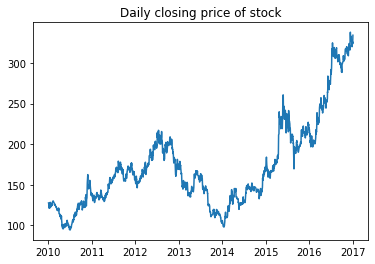

In [3]:
plt.plot(stock_df['Close'])
plt.title('Daily closing price of stock')
plt.show()

In [4]:
print(stock_df.Close['20100104': '20100120'])
# 用插值法拟合出缺失的数据（补充01-09和01-10的数据）
stock_df = stock_df.resample('D').interpolate('linear')
# print(stock_df.Close['20100104': '20100120'])

Date
2010-01-04    127.678436
2010-01-05    127.302780
2010-01-06    125.289253
2010-01-07    123.005257
2010-01-08    121.712997
2010-01-11    121.179565
2010-01-12    124.455299
2010-01-13    121.292259
2010-01-14    126.626595
2010-01-15    127.625847
2010-01-18    128.459808
2010-01-19    127.550713
2010-01-20    124.658150
Name: Close, dtype: float64


In [5]:
# 平稳性检验
diff=0
adf=ADF(stock_df['Close'])
# print(adf)
if adf[1]>0.05:
    print(u'原始序列经检验不平稳,p值为:%s' %(adf[1]))
else:
    print(u'原始序列经检验平稳,p值为:%s' %(adf[1]))

原始序列经检验不平稳,p值为:0.9855780932465037


In [6]:
# 纯随机性检验
from statsmodels.stats.diagnostic import acorr_ljungbox
[[lb],[p]]=acorr_ljungbox(stock_df['Close'], lags=1,return_df=False)
if p<0.05:
    print(u'原始序列为非白噪声序列,p值为:%s'%p)
else:
    print(u'原始序列为白噪声序列,p值为:%s' %p)

原始序列为非白噪声序列,p值为:0.0


                High       Low      Open     Close     Volume  Adj Close
Date                                                                    
2010-01-05 -0.375656 -0.232910 -0.758835 -0.375656 -1702575.0  -0.310791
2010-01-06 -1.502640 -2.021034 -1.502624 -2.013527  1114825.0  -1.665894
2010-01-07 -1.735535 -3.328323 -1.675438 -2.283997  1189451.0  -1.889656
2010-01-08 -2.396690 -1.337341 -2.073624 -1.292259 -1613632.0  -1.069153
2010-01-09  0.225393  0.100174 -0.100177 -0.177811  -543095.0  -0.147110
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object


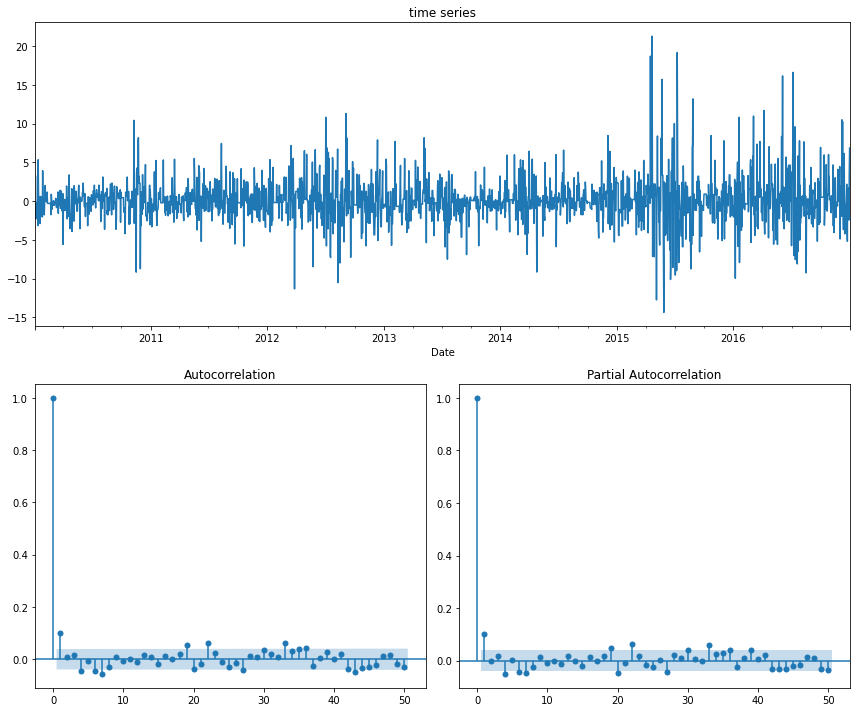

In [7]:
# 采用差分法消除非平稳趋势

stock_diff = stock_df.diff(1)
diff = stock_diff.dropna()
print(diff.head())
print(diff.dtypes)

def plotds(xt, nlag=30, fig_size=(12, 10)):
    if not isinstance(xt, pd.Series):
        xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    # 设置画图布局
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan=2) #最上面是xt图
    ax_acf = plt.subplot2grid(layout, (1, 0)) # 左下角是acf图
    ax_pacf = plt.subplot2grid(layout, (1, 1)) # 右下角是pacf图
    
    # 画出原始序列图像、自相关函数图像、偏相关函数图像
    xt.plot(ax=ax_xt)
    ax_xt.set_title('time series')
    plot_acf(xt, lags=nlag, ax=ax_acf)
    plot_pacf(xt, lags=nlag, ax=ax_pacf)
    plt.tight_layout()

    
plotds(diff['Close'].dropna(), nlag=50)

In [10]:
# 一阶差分序列平稳性检验
from statsmodels.tsa.stattools import adfuller as ADF
adf=ADF(diff['Close'])
if adf[1]>0.05:
    print(u'一阶差分序列经检验不平稳,p值为:%s' %(adf[1]))
else:
    print(u'一阶差分序列经检验平稳,p值为:%s' %(adf[1]))
    


一阶差分序列经检验平稳,p值为:0.0


In [11]:
# 纯随机性检验
from statsmodels.stats.diagnostic import acorr_ljungbox
[[lb],[p]]=acorr_ljungbox(diff['Close'], lags=1,return_df=False)
if p<0.05:
    print(u'原始序列为非白噪声序列,p值为:%s'%p)
else:
    print(u'原始序列为白噪声序列,p值为:%s' %p)

原始序列为非白噪声序列,p值为:3.84830187553991e-07


In [14]:
# ARIMA模型建立
# 导入warnings，忽略warnings
import warnings
warnings.filterwarnings('ignore')
model = ARIMA(stock_df['Close'], order = (2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2552
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6008.501
Method:                       css-mle   S.D. of innovations              2.548
Date:                Sat, 15 May 2021   AIC                          12029.002
Time:                        20:46:52   BIC                          12064.070
Sample:                    01-05-2010   HQIC                         12041.720
                         - 12-30-2016                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0812      0.057      1.436      0.151      -0.030       0.192
ar.L1.D.Close    -0.5127      0.249     -2.060      0.039      -1.000      -0.025
ar.L2.D.Close     0.2269      0.152     

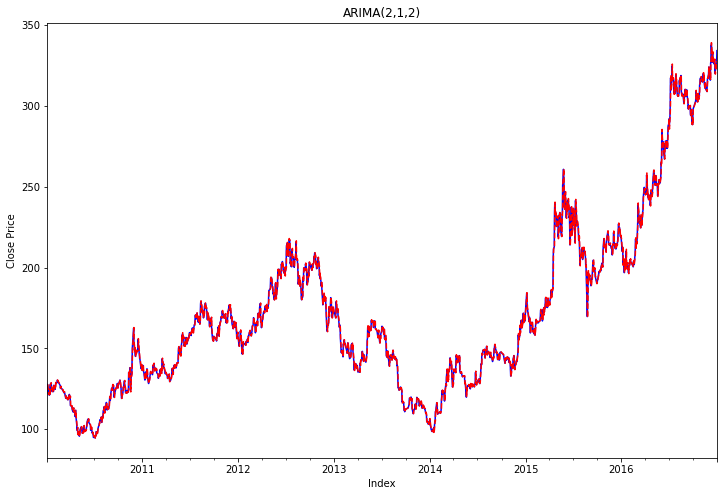

In [15]:
# 模型拟合
stock_df['ARIMA'] = model_fit.predict(typ='levels')
f, axarr = plt.subplots(1, sharex = True)
f.set_size_inches(12, 8)
stock_df['Close'].plot(color = 'b', linestyle = '-', ax=axarr)
stock_df['ARIMA'].plot(color = 'r', linestyle = '--', ax=axarr)
axarr.set_title('ARIMA(2,1,2)')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.show()

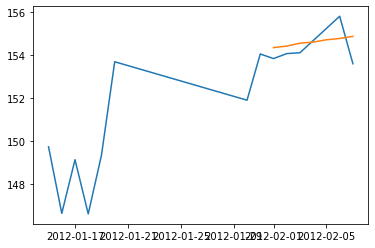

In [19]:
# 5.预测
# 使用模型预测数据
output = model_fit.predict('20120201', '20120207', dynamic=True, typ='levels')
# 展示部分数据真实值
stock_forcast = pd.concat([stock_df.Close['20120115': '20120207'], output], axis=1, keys=['original', 'predicted'])
plt.figure()
plt.plot(stock_forcast)
plt.show()

In [20]:
print(output)  # 打印预测值
print (stock_df.Close['20120201': '20120207'])  # 打印真实值

Date
2012-02-01    154.354582
2012-02-02    154.425296
2012-02-03    154.560732
2012-02-04    154.611692
2012-02-05    154.720650
2012-02-06    154.780701
2012-02-07    154.878989
Freq: D, dtype: float64
Date
2012-02-01    153.842972
2012-02-02    154.074387
2012-02-03    154.115707
2012-02-04    154.683197
2012-02-05    155.250687
2012-02-06    155.818176
2012-02-07    153.603302
Freq: D, Name: Close, dtype: float64


In [22]:
# 对短期预测结果进行评估
short_label = stock_df.Close['20120201': '20120202']
short_prediction = output[:2]
short_mse_score = mse(short_label, short_prediction)
short_rmse_score = math.sqrt(mse(short_label, short_prediction))
short_mae_score = mae(short_label, short_prediction)
print('short_MSE: %.4f, short_RMSE: %.4f, short_MAE: %.4f' % (short_mse_score, short_rmse_score, short_mae_score))

short_MSE: 0.1924, short_RMSE: 0.4387, short_MAE: 0.4313


In [24]:
# 对长期预测结果进行评估
long_label = stock_df.Close['20120201': '20120207']
long_prediction = output
long_mse_score = mse(long_label, long_prediction)
long_rmse_score = math.sqrt(mse(long_label, long_prediction))
long_mae_score = mae(long_label, long_prediction)
print('short_MSE: %.4f, short_RMSE: %.4f, short_MAE: %.4f' % (long_mse_score, long_rmse_score, long_mae_score))

short_MSE: 0.5104, short_RMSE: 0.7144, short_MAE: 0.6032


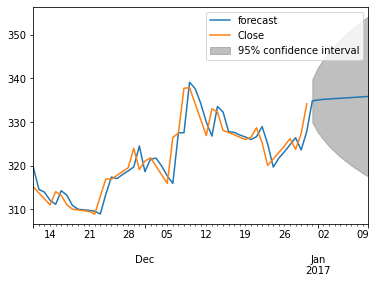

In [25]:
# 对后续数据进行预测
fig = model_fit.plot_predict(len(stock_df)-50, len(stock_df)+10)
predict = model_fit.predict(start=1, end = len(stock_df)+10)